# TSP (Google OR-Tools)

In [99]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)


if __name__ == "__main__":
    main()

Objective: 4384 miles
Route for vehicle 0:
 0 -> 9 -> 5 -> 8 -> 6 -> 2 -> 10 -> 16 -> 14 -> 13 -> 12 -> 11 -> 15 -> 3 -> 4 -> 1 -> 7 -> 0



# TSP (Annealing)

Optimal Route: [0, 13, 12, 11, 15, 3, 4, 1, 7, 5, 8, 6, 2, 10, 16, 14, 9, 0]
Optimal Distance: 4544


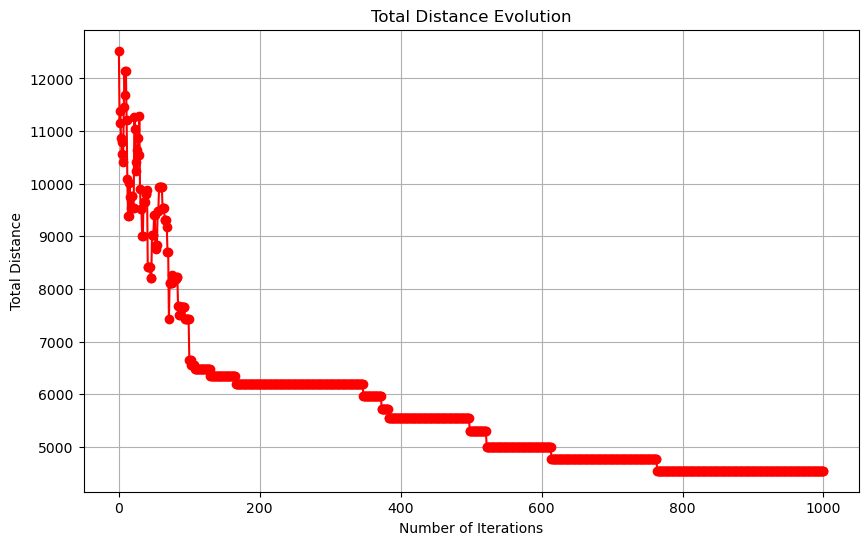

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_total_distance(permutation, dist_matrix):
    """Compute the total distance of the path given a permutation of cities."""
    total_dist = sum(dist_matrix[permutation[i], permutation[i + 1]] for i in range(len(permutation) - 1))
    total_dist += dist_matrix[permutation[-1], permutation[0]]  # Return to the starting city
    return total_dist

def simulated_annealing_tsp(dist_matrix, T, alpha, max_iter):
    num_cities = dist_matrix.shape[0]
    current_permutation = np.arange(num_cities)
    np.random.shuffle(current_permutation[1:])  # Shuffle only non-depot cities
    current_distance = calculate_total_distance(current_permutation, dist_matrix)
    results = [current_distance]
    
    for i in range(max_iter):
        # Generate a new candidate by swapping two non-depot cities
        a, b = np.random.randint(1, num_cities, size=2)  # Ensure depot (index 0) is excluded from swapping
        next_permutation = current_permutation.copy()
        next_permutation[a], next_permutation[b] = next_permutation[b], next_permutation[a]
        
        next_distance = calculate_total_distance(next_permutation, dist_matrix)
        
        # Acceptance probability
        if next_distance < current_distance or np.exp((current_distance - next_distance) / T) > np.random.rand():
            current_permutation, current_distance = next_permutation, next_distance
        
        results.append(current_distance)
        T *= alpha  # Decrease temperature

    return current_permutation, current_distance, results

# Example distance matrix
distance_matrix = np.array([
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ])

# Simulated Annealing parameters
T = 10000.0
alpha = 0.95
max_iter = 1000

# Solve TSP using Simulated Annealing
opt_permutation, opt_distance, results = simulated_annealing_tsp(distance_matrix, T, alpha, max_iter)

print("Optimal Route:", opt_permutation.tolist() + [opt_permutation[0]])
print("Optimal Distance:", opt_distance)
plt.figure(figsize=(10, 6))
plt.plot(results, marker='o', color='red')
plt.title('Total Distance Evolution')
plt.xlabel('Number of Iterations')
plt.ylabel('Total Distance')
plt.grid(True)
plt.show()


# TSP (Genetic)

New best distance: 7168
New best distance: 7100
New best distance: 6916
New best distance: 6528
New best distance: 6164
New best distance: 6072
New best distance: 5912
New best distance: 5868
New best distance: 5708
New best distance: 5616
New best distance: 5320
New best distance: 5160
New best distance: 5068
New best distance: 4840
New best distance: 4544
Best Route: [0, 13, 12, 11, 15, 3, 4, 1, 7, 5, 8, 6, 2, 10, 16, 14, 9, 0]
Best Distance: 4544


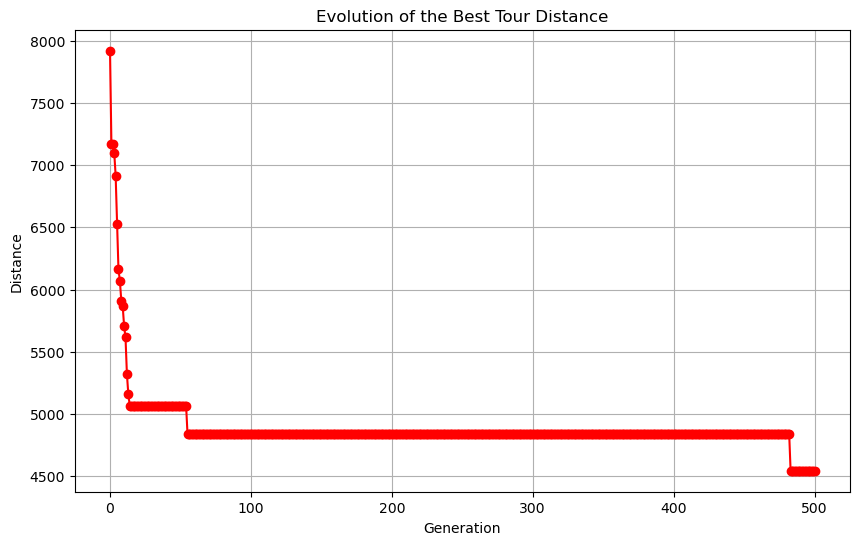

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_cities = 17
population_size = 100
num_generations = 500
tournament_size = 5
mutation_rate = 0.05

# Create a fixed distance matrix
distance_matrix = np.array([
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ])

def calculate_total_distance(route):
    """Calculate total distance of the given route."""
    return sum(distance_matrix[route[i], route[(i + 1) % num_cities]] for i in range(num_cities))

def initialize_population(size, num_cities):
    """Generate an initial population of random routes with fixed depot."""
    population = np.zeros((size, num_cities), dtype=int)
    for i in range(size):
        population[i, 1:] = np.random.permutation(np.arange(1, num_cities))
    return population

def evaluate_fitness(population):
    """Evaluate the fitness of each individual in the population."""
    return np.array([calculate_total_distance(ind) for ind in population])

def tournament_selection(population, fitness, tournament_size):
    """Select parents via tournament selection."""
    parents = []
    for _ in range(len(population)):
        indices = np.random.randint(0, len(population), tournament_size)
        best_idx = indices[np.argmin(fitness[indices])]
        parents.append(population[best_idx])
    return np.array(parents)

def ordered_crossover(parent1, parent2):
    """Perform an ordered crossover while keeping depot fixed."""
    size = len(parent1)
    child = -np.ones(size, dtype=int)
    child[0] = 0  # Start with the depot
    start, end = sorted(np.random.choice(range(1, size), 2, replace=False))
    child[start:end+1] = parent1[start:end+1]

    # Fill remaining slots with cities from parent2 without duplication
    p2_filtered = [city for city in parent2 if city not in child and city != 0]
    fill_indices = list(range(1, start)) + list(range(end + 1, size))
    for idx, city in zip(fill_indices, p2_filtered):
        child[idx] = city

    return child

def mutate(route, rate=0.05):
    """Perform swap mutation on the route excluding the depot."""
    if np.random.rand() < rate:
        idxs = np.arange(1, len(route))  # Exclude the depot (index 0)
        swap_idx1, swap_idx2 = np.random.choice(idxs, 2, replace=False)
        route[swap_idx1], route[swap_idx2] = route[swap_idx2], route[swap_idx1]
    return route

def genetic_algorithm():
    """Run the genetic algorithm."""
    population = initialize_population(population_size, num_cities)
    fitness = evaluate_fitness(population)
    best_idx = np.argmin(fitness)
    best_distance = fitness[best_idx]
    best_route = population[best_idx].copy()
    
    results = [best_distance]

    for _ in range(num_generations):
        parents = tournament_selection(population, fitness, tournament_size)
        offspring = np.array([ordered_crossover(parents[i % len(parents)], parents[(i+1) % len(parents)]) for i in range(len(population))])
        offspring = np.array([mutate(child, mutation_rate) for child in offspring])
        offspring_fitness = evaluate_fitness(offspring)
        
        # Combine and keep the best
        combined_population = np.concatenate((population, offspring))
        combined_fitness = np.concatenate((fitness, offspring_fitness))
        best_indices = np.argsort(combined_fitness)[:population_size]
        population = combined_population[best_indices]
        fitness = combined_fitness[best_indices]
        
        current_best_idx = np.argmin(fitness)
        current_best = fitness[current_best_idx]
        results.append(current_best)
        if current_best < best_distance:
            best_distance = current_best
            best_route = population[current_best_idx].copy()
            print(f"New best distance: {best_distance}")

    return best_route, best_distance, results

# Run the genetic algorithm
best_route, best_distance, results = genetic_algorithm()

print("Best Route:", best_route.tolist() + [best_route[0]])
print("Best Distance:", best_distance)

plt.figure(figsize=(10, 6))
plt.plot(results, marker='o', color='red')
plt.title('Evolution of the Best Tour Distance')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


# 4VRP (Annealing)

Optimal Routes:
Vehicle 1 Route: [0, 7, 3, 8, 6, 12, 0]
Vehicle 2 Route: [0, 9, 5, 0]
Vehicle 3 Route: [0, 16, 4, 15, 11, 14, 0]
Vehicle 4 Route: [0, 10, 2, 1, 13, 0]
Optimal Total Distance: 8536


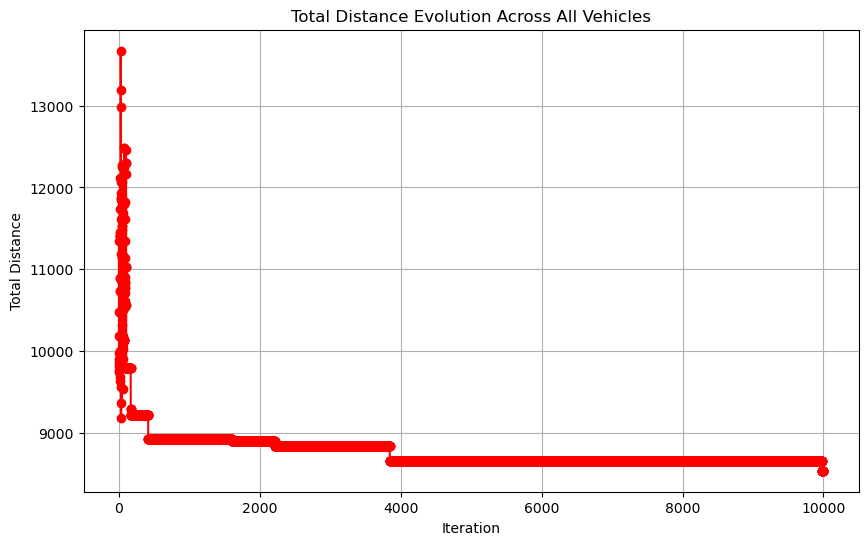

In [205]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_cities = 17
num_vehicles = 4
T = 100000.0
alpha = 0.95
max_iter = 10000

# Create a random distance matrix
distance_matrix = np.array([
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ])

def calculate_total_distance(routes):
    """Calculate the total distance for all routes."""
    total_distance = 0
    for route in routes:
        if len(route) > 1:  # Ensure route has at least two cities to form a path
            total_distance += sum(distance_matrix[route[i], route[(i + 1) % len(route)]] for i in range(len(route)))
            total_distance += distance_matrix[route[-1], route[0]]  # Return to the starting city of the route
    return total_distance

def initialize_routes(num_cities, num_vehicles):
    """Initialize random routes for each vehicle."""
    cities = np.random.permutation(np.arange(1, num_cities))  # Exclude depot assumed at index 0
    split_points = np.sort(np.random.choice(np.arange(1, num_cities-1), num_vehicles-1, replace=False))
    routes = np.split(cities, split_points)
    return [[0] + route.tolist() + [0] for route in routes]  # Each route starts/ends at the depot

def simulated_annealing_vrp(dist_matrix, T, alpha, max_iter, num_vehicles):
    routes = initialize_routes(num_cities, num_vehicles)
    current_distance = calculate_total_distance(routes)
    results = [current_distance]

    for _ in range(max_iter):
        new_routes = mutate_routes(routes, num_cities, dist_matrix)
        new_distance = calculate_total_distance(new_routes)
        
        if new_distance < current_distance or np.exp((current_distance - new_distance) / T) > np.random.rand():
            routes, current_distance = new_routes, new_distance

        results.append(current_distance)
        T *= alpha

    return routes, current_distance, results

def mutate_routes(routes, num_cities, dist_matrix):
    """Perform a mutation on the routes."""
    # Example mutation: swap two cities in two different routes
    if len(routes) > 1:
        route1, route2 = np.random.choice(len(routes), 2, replace=False)
        if len(routes[route1]) > 2 and len(routes[route2]) > 2:  # Ensure routes can be swapped
            idx1, idx2 = np.random.randint(1, len(routes[route1])-1), np.random.randint(1, len(routes[route2])-1)
            routes[route1][idx1], routes[route2][idx2] = routes[route2][idx2], routes[route1][idx1]
    return routes

# Run the VRP simulation
routes, final_distance, results = simulated_annealing_vrp(distance_matrix, T, alpha, max_iter, num_vehicles)

print("Optimal Routes:")
for i, route in enumerate(routes):
    print(f"Vehicle {i+1} Route: {route}")
print("Optimal Total Distance:", final_distance)

plt.figure(figsize=(10, 6))
plt.plot(results, marker='o', color='red')
plt.title('Total Distance Evolution Across All Vehicles')
plt.xlabel('Iteration')
plt.ylabel('Total Distance')
plt.grid(True)
plt.show()


# 4VRP (Genetic)

New best distance: 8468
New best distance: 8240
New best distance: 7692
New best distance: 7532
New best distance: 7372
Optimal Solution:
Vehicle 1 Route: [0, 1, 3, 4, 7, 0]
Vehicle 2 Route: [0, 14, 15, 11, 12, 0]
Vehicle 3 Route: [0, 13, 16, 10, 6, 0]
Vehicle 4 Route: [0, 9, 5, 2, 8, 0]
Optimal Total Distance: 7372


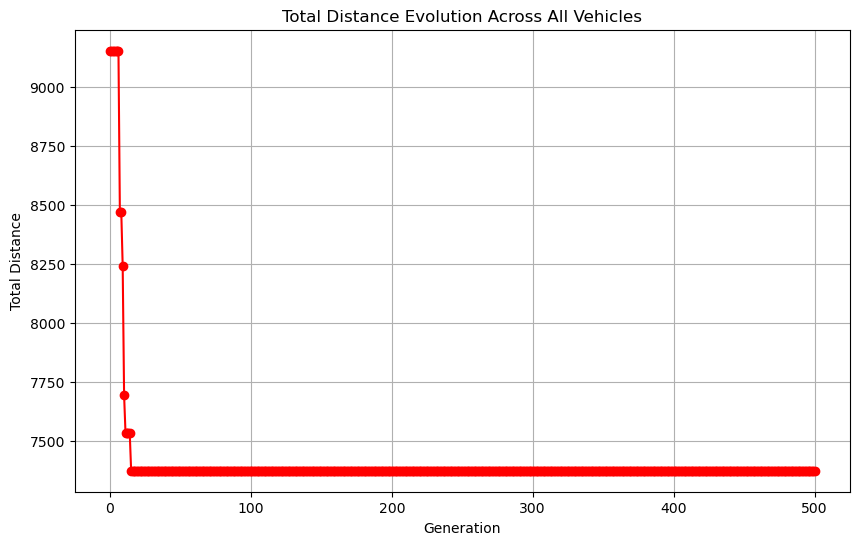

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
num_cities = 17
num_vehicles = 4
population_size = 100
num_generations = 500
tournament_size = 5
mutation_rate = 0.05

# Create a random distance matrix
distance_matrix = np.array([
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ])

def calculate_total_distance(routes):
    """ Calculate the total distance for all routes. """
    total_distance = 0
    for route in routes:
        total_distance += sum(distance_matrix[route[i], route[(i + 1) % len(route)]] for i in range(len(route) - 1))
        total_distance += distance_matrix[route[-1], route[0]]  # Complete the loop
    return total_distance

def initialize_population(size, num_cities, num_vehicles):
    """ Initialize random routes for each vehicle ensuring all cities are covered once. """
    population = []
    for _ in range(size):
        cities = np.random.permutation(np.arange(1, num_cities))
        splits = np.array_split(cities, num_vehicles)
        population.append([[0] + list(split) + [0] for split in splits])
    return population

def evaluate_fitness(population):
    """ Evaluate the fitness of each individual in the population. """
    return np.array([calculate_total_distance(routes) for routes in population])

def tournament_selection(population, fitness, tournament_size):
    """ Select parents via tournament selection. """
    parents = []
    for _ in range(len(population)):
        indices = np.random.randint(0, len(population), tournament_size)
        best_idx = indices[np.argmin(fitness[indices])]
        parents.append(population[best_idx])
    return parents  # Return list of parents

def mutate(route, rate=0.05):
    """ Perform mutation on the route by swapping two cities in each vehicle's route. """
    for r in route:
        if np.random.rand() < rate:
            idxs = np.random.choice(range(1, len(r) - 1), 2, replace=False)  # Ensure not to swap the depot
            r[idxs[0]], r[idxs[1]] = r[idxs[1]], r[idxs[0]]
    return route

def ordered_crossover(parent1, parent2):
    """ Perform ordered crossover for VRP, ensuring valid routes. """
    child = []
    for route1, route2 in zip(parent1, parent2):
        route1, route2 = list(route1), list(route2)
        size = len(route1)
        start, end = sorted(np.random.choice(range(1, size - 1), 2, replace=False))
        middle = route1[start:end+1]
        remaining = [city for city in route2 if city not in middle and city != 0]

        new_route = [0] + remaining[:start-1] + middle + remaining[start-1:] + [0]
        child.append(new_route)

    return child if child else None


def genetic_algorithm():
    population = initialize_population(population_size, num_cities, num_vehicles)
    fitness = evaluate_fitness(population)
    best_idx = np.argmin(fitness)
    best_distance = fitness[best_idx]
    best_solution = population[best_idx]
    
    results = [best_distance]

    for _ in range(num_generations):
        parents = tournament_selection(population, fitness, tournament_size)
        offspring = [ordered_crossover(parents[i % len(parents)], parents[(i+1) % len(parents)]) for i in range(len(parents))]
        offspring = [mutate(child, mutation_rate) for child in offspring]
        offspring_fitness = evaluate_fitness(offspring)
        
        # Combine and keep the best
        combined_population = population + offspring
        combined_fitness = np.concatenate((fitness, offspring_fitness))
        best_indices = np.argsort(combined_fitness)[:population_size]
        population = [combined_population[i] for i in best_indices]
        fitness = combined_fitness[best_indices]        
        current_best_idx = np.argmin(fitness)
        current_best = fitness[current_best_idx]
        results.append(current_best)
        if current_best < best_distance:
            best_distance = current_best
            best_solution = population[current_best_idx]
            print(f"New best distance: {best_distance}")

    return best_solution, best_distance, results

# Run the genetic algorithm
best_solution, best_distance, results = genetic_algorithm()

print("Optimal Solution:")
for i, route in enumerate(best_solution):
    print(f"Vehicle {i+1} Route: {route}")
print("Optimal Total Distance:", best_distance)

plt.figure(figsize=(10, 6))
plt.plot(results, marker='o', color='red')
plt.title('Total Distance Evolution Across All Vehicles')
plt.xlabel('Generation')
plt.ylabel('Total Distance')
plt.grid(True)
plt.show()



# 4VRP (Google OR-Tools)

In [206]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")



def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")


if __name__ == "__main__":
    main()

Objective: 177500
Route for vehicle 0:
 0 ->  9 ->  10 ->  2 ->  6 ->  5 -> 0
Distance of the route: 1712m

Route for vehicle 1:
 0 ->  16 ->  14 ->  8 -> 0
Distance of the route: 1484m

Route for vehicle 2:
 0 ->  7 ->  1 ->  4 ->  3 -> 0
Distance of the route: 1552m

Route for vehicle 3:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Maximum of the route distances: 1712m


# CVRP (Genetic)

In [429]:
import numpy as np
import random

# Parameters
num_cities = 17  # Including the depot
num_vehicles = 4
vehicle_capacity = 15 # for the sake of simplicity
population_size = 10
generations = 50
mutation_rate = 0.05
tournament_size = 50
demands = np.array([0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]) # preset demands for the nodes
distance_matrix = np.array([
    # fmt: off
    [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
    [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
    [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
    [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
    [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
    [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
    [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
    [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
    [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
    [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
    [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
    [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
    [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
    [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
    [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
    [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
    [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
    # fmt: on
])

# Heuristic Initialization: Modified Nearest Neighbor Heuristic (NNH) with Randomness
def modified_nearest_neighbor_heuristic(distance_matrix, demands, vehicle_capacity, num_vehicles):
    num_nodes = len(distance_matrix)
    unvisited = set(range(1, num_nodes))  # excluding the depot
    routes = []
    while unvisited and len(routes) < num_vehicles:
        start_node = random.choice(list(unvisited))  # Start from a random depot
        route = [0, start_node]
        load = demands[start_node]
        unvisited.remove(start_node)

        while unvisited:
            last = route[-1]
            # Find the closest nodes and break ties randomly
            min_distance = min(distance_matrix[last][node] for node in unvisited)
            closest_nodes = [node for node in unvisited if distance_matrix[last][node] == min_distance]
            next_node = random.choice(closest_nodes)
            
            if load + demands[next_node] > vehicle_capacity:
                break
            
            route.append(next_node)
            load += demands[next_node]
            unvisited.remove(next_node)
        
        route.append(0)  # Return to the depot
        routes.append(route)
    return routes

def random_initialization(num_nodes, demands, vehicle_capacity, num_vehicles):
    nodes = list(range(1, num_nodes))
    random.shuffle(nodes)
    routes = []
    while nodes and len(routes) < num_vehicles:
        route = [0]
        load = 0
        while nodes:
            next_node = nodes[0]
            if load + demands[next_node] > vehicle_capacity:
                break
            route.append(next_node)
            load += demands[next_node]
            nodes.pop(0)
        route.append(0)
        routes.append(route)
    return routes

# Fitness Function
def calculate_cost(route, distance_matrix):
    cost = 0 # init the cost for the all vehicle for one possible population (solution)
    for i in range(len(route) - 1): # 
        cost += distance_matrix[route[i]][route[i + 1]]
    return cost

def evaluate_population(population, distance_matrix):
    fitness_scores = [] # placeholder for all cost in this population
    for individual in population:
        cost = sum(calculate_cost(route, distance_matrix) for route in individual)
        fitness_scores.append(cost)
    return fitness_scores

def tournament_selection(population, fitness):
    """Select parents via tournament selection."""
    parents = []
    for _ in range(len(population)):
        indices = np.random.randint(0, len(population), 250)
        best_idx = indices[np.argmin([fitness[i] for i in indices])]
        parents.append(population[best_idx])
    return parents

# Crossover
def order_crossover(parent1, parent2):
    def ox1(p1, p2):
        size = len(p1)
        child = [-1] * size
        start, end = sorted(random.sample(range(size), 2))
        child[start:end] = p1[start:end]
        p2_idx = 0
        for i in range(size):
            if child[i] == -1:
                while p2_idx < size and p2[p2_idx] in child:
                    p2_idx += 1
                if p2_idx < size:
                    child[i] = p2[p2_idx]
        return child
    
    child1 = []
    child2 = []
    for r1, r2 in zip(parent1, parent2):
        c1 = ox1(r1, r2)
        c2 = ox1(r2, r1)
        child1.append(c1)
        child2.append(c2)
    
    return child1, child2

# Mutation
def mutate(individual, mutation_rate):
    for route in individual:
        if random.random() < mutation_rate:
            i, j = random.sample(range(1, len(route) - 1), 2)
            route[i], route[j] = route[j], route[i]

# Repair function to fix invalid routes
def repair_individual(individual, demands, vehicle_capacity):
    nodes = set(range(1, len(demands)))
    visited = set()
    repaired_individual = []
    for route in individual:
        repaired_route = [0]
        load = 0
        for node in route[1:-1]:
            if node in nodes and node not in visited:
                if load + demands[node] <= vehicle_capacity:
                    repaired_route.append(node)
                    load += demands[node]
                    visited.add(node)
        repaired_route.append(0)
        repaired_individual.append(repaired_route)

    # Add missing nodes
    missing_nodes = nodes - visited
    for node in missing_nodes:
        for route in repaired_individual:
            if sum(demands[n] for n in route) + demands[node] <= vehicle_capacity:
                route.insert(-1, node)
                break

    # Ensure all routes start and end with 0 (depot)
    for route in repaired_individual:
        if route[0] != 0:
            route.insert(0, 0)
        if route[-1] != 0:
            route.append(0)
    
    return repaired_individual

population = []
for _ in range(population_size//2):
    population.append(modified_nearest_neighbor_heuristic(distance_matrix, demands, vehicle_capacity, num_vehicles))
for _ in range(population_size // 2, population_size):
    population.append(random_initialization(num_cities, demands, vehicle_capacity, num_vehicles))

for generation in range(generations):
    fitness_scores = evaluate_population(population, distance_matrix)
    new_population = []

    for _ in range(population_size//2):
        parents = tournament_selection(population, fitness_scores)
        parent1, parent2 = random.sample(parents, 2)
        child1, child2 = order_crossover(parent1, parent2)
        mutate(child1, mutation_rate)
        mutate(child2, mutation_rate)
        child1 = repair_individual(child1, demands, vehicle_capacity)
        child2 = repair_individual(child2, demands, vehicle_capacity)
        new_population.extend([child1, child2])

    population = new_population

# Final Solution
fitness_scores = evaluate_population(population, distance_matrix)
best_solution = population[np.argmin(fitness_scores)]
best_cost = min(fitness_scores)
print("Best solution:", best_solution)
print("Cost:", best_cost)


  0%|          | 0/50 [00:00<?, ?it/s]

Best solution: [[0, 5, 2, 6, 8, 0], [0, 13, 15, 11, 12, 0], [0, 14, 16, 10, 9, 0], [0, 1, 4, 3, 7, 0]]
Cost: 6208


# CVRP (Google OR-Tools)

In [431]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["demands"] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data["vehicle_capacities"] = [15, 15, 15, 15]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")


def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == "__main__":
    main()

Objective: 6208
Route for vehicle 0:
 0 Load(0) ->  4 Load(4) ->  3 Load(6) ->  1 Load(7) ->  7 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  14 Load(4) ->  16 Load(12) ->  10 Load(14) ->  9 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  12 Load(2) ->  11 Load(3) ->  15 Load(11) ->  13 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  8 Load(8) ->  2 Load(9) ->  6 Load(13) ->  5 Load(15) ->  0 Load(15)
Distance of the route: 1552m
Load of the route: 15

Total distance of all routes: 6208m
Total load of all routes: 60
